# Data mining \& clustering

The goal if this practical is to adress the folowing problem: 
<center style="color:red" >  Given XXX raw, unlabeled documents, ... How to exploit/understand/represent them?</center>

In the previous week, we have seen how to represent textual data with the Bag of Words (BoW) model:
$$X = 
	\begin{matrix} 
	 & \textbf{t}_j \\
	 & \downarrow \\
	\textbf{d}_i \rightarrow &
	\begin{pmatrix} 
	x_{1,1} & \dots & x_{1,d} \\
	\vdots & \ddots & \vdots \\
	x_{N,1} & \dots & x_{N,d} \\
	\end{pmatrix}
	\end{matrix}
	$$

From this BoW representation, we want to answer the following questions:
1. Which clustering algorithm to choose?
    - K-means, LSA, pLSA, LDA
1. What results to expect?
    - Semantics, noise cleaning, etc...
1. Which qualitative and quantitative analyses to understand the groups?
[comment]: <> (%1. Comment boucler, itérer pour améliorer la qualité du processus?)


<span style="color:magenta" > In this practical, we use a **labeled dataset** in order to evaluate performances with quantitative and well-defined metrics. </span>


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import codecs
import re
import os.path
import sklearn

## Data loading



In [2]:
from sklearn.datasets import fetch_20newsgroups
newsgroups_train = fetch_20newsgroups(subset='train')

In [3]:
# conversion BoW + tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer
#vectorizer = TfidfVectorizer() 
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=1000, stop_words='english')

vectors = vectorizer.fit_transform(newsgroups_train.data)
print(vectors.shape)

# sparsity measure = 44 active words over 1000 per document (157 over 130000) !!
print(vectors.nnz / float(vectors.shape[0]))

(11314, 1000)
44.164928407283014


In [4]:
# retrieve words
print([(i,vectorizer.get_feature_names_out()[i]) \
       for i in np.random.randint(vectors.shape[1], size=10)])

[(698, 'points'), (581, 'man'), (603, 'military'), (783, 'russian'), (347, 'education'), (58, '46'), (748, 'reasonable'), (284, 'cut'), (385, 'fi'), (521, 'keys')]


In [5]:
# labels (only for evaluation)
Y = newsgroups_train.target
print(Y[:10]) 
print([newsgroups_train.target_names[i] for i in Y[:20]]) # vraie classe

[ 7  4  4  1 14 16 13  3  2  4]
['rec.autos', 'comp.sys.mac.hardware', 'comp.sys.mac.hardware', 'comp.graphics', 'sci.space', 'talk.politics.guns', 'sci.med', 'comp.sys.ibm.pc.hardware', 'comp.os.ms-windows.misc', 'comp.sys.mac.hardware', 'rec.motorcycles', 'talk.religion.misc', 'comp.sys.mac.hardware', 'sci.space', 'misc.forsale', 'alt.atheism', 'comp.graphics', 'rec.autos', 'sci.electronics', 'comp.windows.x']


# 0) Word clouds 
### Drawing word clouds from the raw corpus or words' frequencies :  [make word clouds !](https://github.com/amueller/word_cloud)

### Installation
If you are using pip:

`pip install wordcloud`

### If you are using conda, you can install from the conda-forge channel:

`conda install -c conda-forge wordcloud`

### Let's look at the most frequent words in this dataset

In [6]:
data = np.array(newsgroups_train.data)
corpus = "".join(data)
words = corpus.split() # optional args to choose the splitting chars
print("Nb mots=",len(words))
# Lets find the most frequence words Your code here

Nb mots= 3252437


In [7]:
# Your code here
from collections import Counter 
from wordcloud import WordCloud

def N_most_frequent_words(vectorizer, words, N):
    X = vectorizer.fit_transform(words)
    vocab = vectorizer.get_feature_names_out()
    count = X.sum(axis=0).T #somme sur les colonnes
    counter_word_count = Counter({vocab[i] : int(count[i]) for i in range(len(vocab))})
    topN = counter_word_count.most_common(N)    
    return dict(topN)

most_frequent_words = N_most_frequent_words(vectorizer, words, 100)

### Plot the N frequent words and verify that its follows a Zipf law

In [8]:
print(most_frequent_words)

{'edu': 15147, 'subject': 12262, 'lines': 11832, 'organization': 11223, 'com': 9657, 'writes': 7844, 'article': 7436, 'people': 5971, 'don': 5946, 'like': 5847, 'ax': 5639, 'just': 5600, 'university': 5584, 'know': 5127, 'think': 4559, 'use': 4177, 'does': 4134, 'time': 4056, 'new': 3959, 'good': 3751, 'posting': 3451, 'ca': 3154, 'way': 2998, 'god': 2991, 'host': 2975, 'make': 2892, 'nntp': 2802, 'distribution': 2765, 'right': 2730, 'say': 2702, 'world': 2671, 've': 2564, 'want': 2512, 'reply': 2462, 'said': 2452, 'used': 2452, 'did': 2438, 'need': 2410, 'work': 2359, '10': 2244, 'problem': 2220, 'cs': 2179, 'really': 2174, 'computer': 2139, 'state': 2080, 'believe': 2024, 'going': 2015, 'year': 2009, 'file': 1997, 'mail': 1985, 'information': 1981, 'help': 1918, 'years': 1917, 'using': 1898, 'question': 1868, 'windows': 1863, 'point': 1851, 'thanks': 1851, 'll': 1837, 'government': 1806, 'things': 1795, 'better': 1791, 'space': 1786, 'usa': 1744, 'number': 1712, 'sure': 1697, 'read':

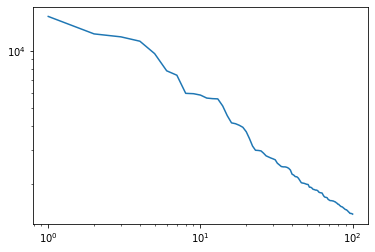

In [9]:
nb_most_frequent_words = [most_frequent_words[m] for m in most_frequent_words.keys()]
plt.loglog(range(1,len(nb_most_frequent_words)+1), nb_most_frequent_words)
plt.show()

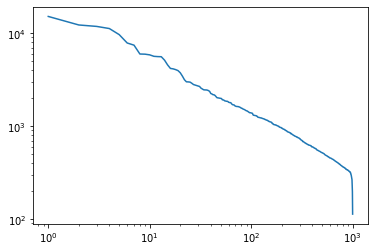

In [10]:
def zipf_law(corpus):
    X = vectorizer.fit_transform(corpus)
    vocab = vectorizer.get_feature_names_out()
    count = X.sum(axis=0).T #somme sur les colonnes
    counter_word_count = Counter({vocab[i] : int(count[i]) for i in range(len(vocab))})
    word_count = dict(counter_word_count)
    word_count = sorted(word_count.items(), key=lambda x:x[1], reverse=True)
    nb = [n for _,n in word_count]
    plt.loglog(range(1,len(nb)+1), nb)
    plt.show()

zipf_law(words)

### Experiment word clouds

(-0.5, 399.5, 199.5, -0.5)

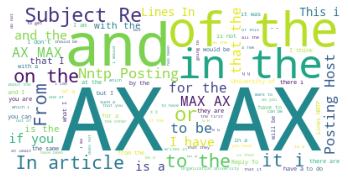

In [11]:
wordcloud = WordCloud(background_color='white', stopwords = [], max_words=100).generate(corpus)            

plt.figure()
plt.imshow(wordcloud)
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

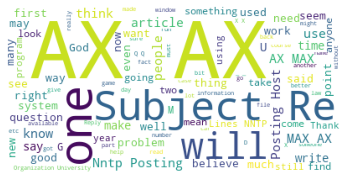

In [12]:
from wordcloud import STOPWORDS # Note: this is the default option           
wordcloud = WordCloud(background_color='white', stopwords = STOPWORDS, max_words=100).generate(corpus) 

plt.figure()
plt.imshow(wordcloud)
plt.axis("off")

### Use word clouds with generate\_from\_frequencies. 
N.B.: retrieve the most words frequencies using a CountVectorizer

In [14]:
# Your code here
from wordcloud import STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer
vectorizerC = CountVectorizer(stop_words='english')
X = vectorizerC.fit_transform(words)
vocab = vectorizerC.get_feature_names_out()
count = X.sum(axis=0).T #somme sur les colonnes
counter_word_count = Counter({vocab[i] : int(count[i]) for i in range(len(vocab))})
print(counter_word_count)
most_frequent_words = counter_word_count.most_common(100)   



Counter({'ax': 62406, 'edu': 21321, 'subject': 12264, 'com': 12133, 'lines': 11835, 'organization': 11233, 'writes': 7844, 'article': 7438, 'people': 5975, 'don': 5953, 'like': 5865, 'just': 5602, 'university': 5586, 'posting': 5507, 'know': 5128, 'host': 4996, 'nntp': 4814, 'max': 4690, 'think': 4578, 'use': 4183, 'does': 4135, 'time': 4093, 'new': 3971, 'good': 3758, 'ca': 3544, 'cs': 3036, 'way': 3002, 'god': 2994, 'make': 2894, 'distribution': 2766, 'right': 2739, 'world': 2721, 'say': 2704, 've': 2568, 'want': 2515, 'reply': 2463, '10': 2462, 'used': 2456, 'said': 2453, 'did': 2439, 'need': 2413, 'work': 2366, 'state': 2268, 'problem': 2224, 'really': 2175, 'computer': 2149, 'mail': 2058, 'year': 2055, 'believe': 2026, 'going': 2016, 'file': 2005, 'information': 1983, 'windows': 1953, 'help': 1924, 'years': 1919, 'using': 1898, 'question': 1871, 'point': 1862, 'll': 1858, 'space': 1856, 'thanks': 1853, 'government': 1814, '15': 1807, 'things': 1795, 'better': 1793, '20': 1780, '16

In [15]:
print(X)

  (1, 75215)	1
  (1, 122887)	1
  (1, 118013)	1
  (1, 50455)	1
  (4, 114439)	1
  (5, 111094)	1
  (7, 37722)	1
  (10, 87451)	1
  (10, 94962)	1
  (10, 63970)	1
  (11, 122887)	1
  (11, 118013)	1
  (11, 50455)	1
  (11, 98748)	1
  (12, 90192)	1
  (13, 118714)	1
  (15, 79519)	1
  (16, 40939)	1
  (17, 91885)	1
  (18, 75888)	1
  (19, 4605)	1
  (22, 124627)	1
  (28, 51714)	1
  (32, 37722)	1
  (34, 104609)	1
  :	:
  (3252402, 72279)	1
  (3252403, 38267)	1
  (3252404, 106000)	1
  (3252405, 88185)	1
  (3252406, 69881)	1
  (3252407, 51651)	1
  (3252408, 88185)	1
  (3252409, 8653)	1
  (3252411, 116769)	1
  (3252412, 107124)	1
  (3252414, 82202)	1
  (3252415, 75740)	1
  (3252416, 113204)	1
  (3252419, 115763)	1
  (3252420, 101747)	1
  (3252421, 106061)	1
  (3252423, 124069)	1
  (3252424, 109434)	1
  (3252425, 115361)	1
  (3252426, 60694)	1
  (3252427, 76233)	1
  (3252428, 82327)	1
  (3252431, 62582)	1
  (3252435, 31354)	1
  (3252436, 72741)	1


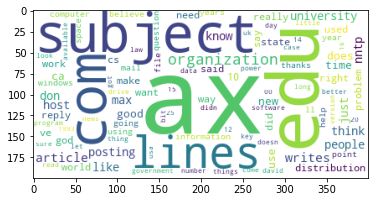

In [17]:
# Your code here
wordcloud = WordCloud(background_color = 'white', max_words = 100).generate_from_frequencies(dict(most_frequent_words))
plt.imshow(wordcloud)

### Drawing word clouds from classes


In [18]:
print([newsgroups_train.target_names[i] for i in Y[:20]]) # vraie classe

['rec.autos', 'comp.sys.mac.hardware', 'comp.sys.mac.hardware', 'comp.graphics', 'sci.space', 'talk.politics.guns', 'sci.med', 'comp.sys.ibm.pc.hardware', 'comp.os.ms-windows.misc', 'comp.sys.mac.hardware', 'rec.motorcycles', 'talk.religion.misc', 'comp.sys.mac.hardware', 'sci.space', 'misc.forsale', 'alt.atheism', 'comp.graphics', 'rec.autos', 'sci.electronics', 'comp.windows.x']


In [19]:
import string 

def del_punc(text):    
    punc = string.punctuation  
    punc += '\n\r\t'
    text = text.translate(str.maketrans(punc, ' ' * len(punc)))  
    return text


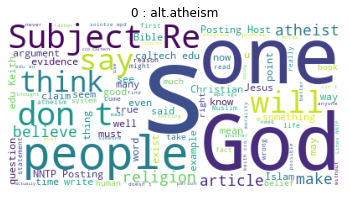

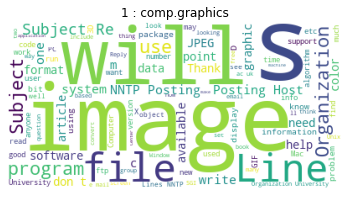

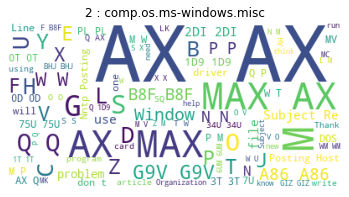

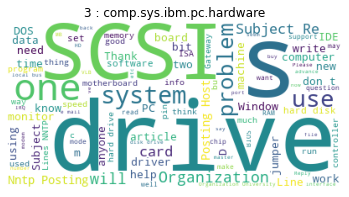

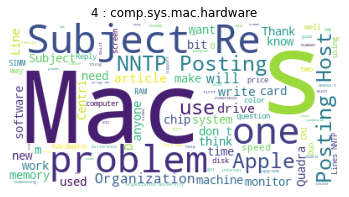

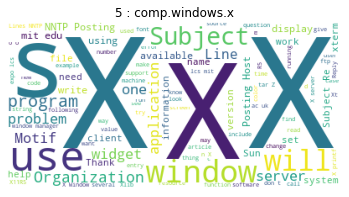

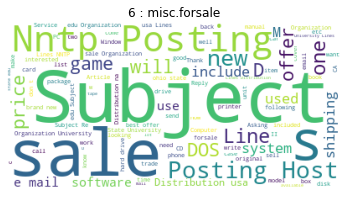

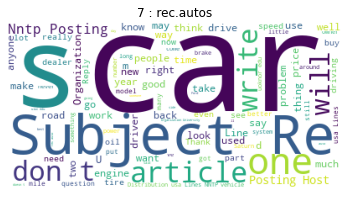

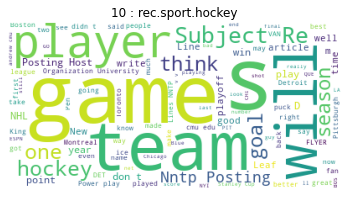

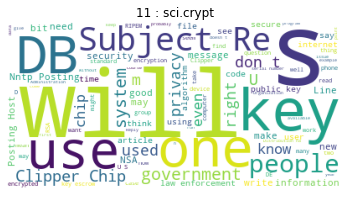

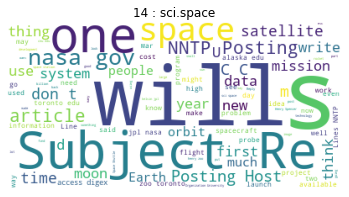

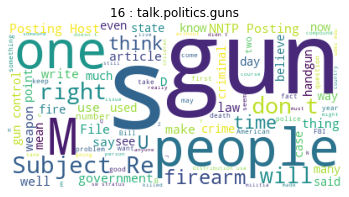

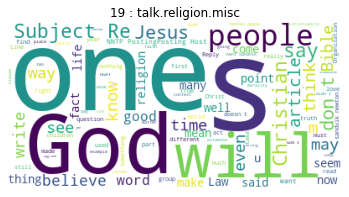

In [20]:
#Pour chaque label de Y (20)
for y in np.unique(Y) : 
    #Y = newsgroup_train.target
    y_words = data[np.where(Y == y)[0]] #récupère les documents de label y
    y_words = ' '.join(y_words)
    y_words = del_punc(y_words)

    wordcloud = WordCloud(background_color = 'white', max_words = 100, stopwords = STOPWORDS).generate(y_words)
    plt.figure()
    plt.title(str(y)+" : "+newsgroups_train.target_names[y])
    plt.imshow(wordcloud)
    plt.axis("off")

# 1) Clustering algorithm: K-Means

**Let's start by the most famous and simple unsupervised algorithm: $k$-means!**
Look at [sklear documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)
and apply it to your BoW matrix.


In [21]:
from sklearn.cluster import KMeans
# your code here
kmeans = KMeans(n_clusters=20, random_state=0, max_iter=10).fit(vectors)
# Getting clusters:
clusters = kmeans.cluster_centers_


/home/nour/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


### Clustering Analysis: 
1. **Qualtitative:**
    - Look at the most important words for each cluster
    - Perform cluster assignement to each document, and compute word cloud on the document (raw text or frequencies)
2. **Quantitative:**
    - Compute cluster "purity": $p_j= \frac{|y^*|}{|C_j|}$, where $y^*$ is the most frequent (GT) label in cluster $C$ $\Rightarrow$ $p = \sum\limits_j |C_j| p_j$
    - Compute [Rand Score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.rand_score.html) and [Adjusted Rand Score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html#sklearn.metrics.adjusted_rand_score) 

In [22]:
ind_most_imp_word = clusters.argmax(1)
print(ind_most_imp_word)
vocab = vectorizer.get_feature_names_out()
print("Mot le plus important du : ")
for cluster, mot in enumerate(ind_most_imp_word):
    print("\t _ cluster %d : %s" % (cluster, vectorizer.get_feature_names_out()[mot]))


[202 679 241 622 193 409 519 977 687 923 505 976 346 336 787 185 427 285
 104 924]
Mot le plus important du : 
	 _ cluster 0 : cd
	 _ cluster 1 : people
	 _ cluster 2 : come
	 _ cluster 3 : national
	 _ cluster 4 : cards
	 _ cluster 5 : games
	 _ cluster 6 : keyboard
	 _ cluster 7 : windows
	 _ cluster 8 : pitt
	 _ cluster 9 : type
	 _ cluster 10 : israeli
	 _ cluster 11 : window
	 _ cluster 12 : education
	 _ cluster 13 : driver
	 _ cluster 14 : sale
	 _ cluster 15 : cable
	 _ cluster 16 : goes
	 _ cluster 17 : cx
	 _ cluster 18 : anonymous
	 _ cluster 19 : uiuc


In [23]:
clusters.shape

(20, 1000)

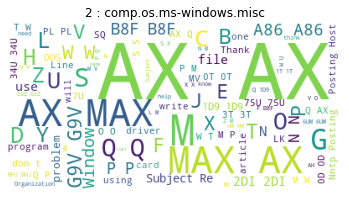

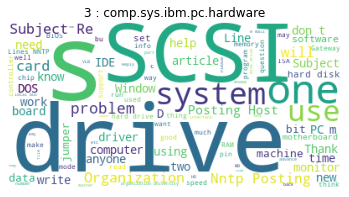

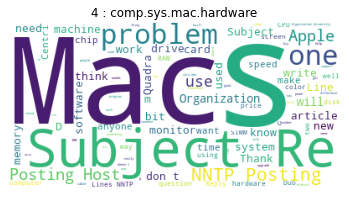

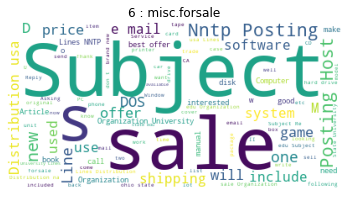

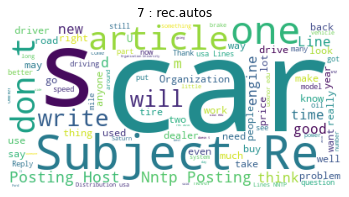

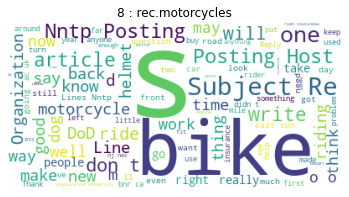

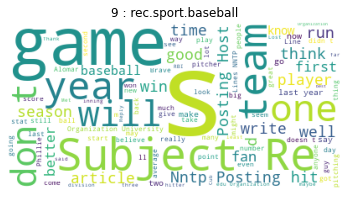

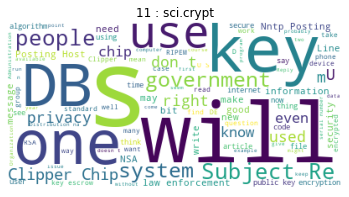

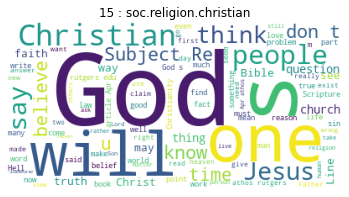

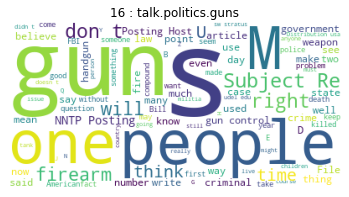

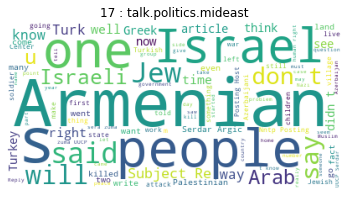

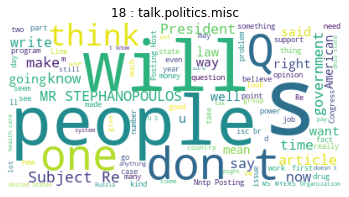

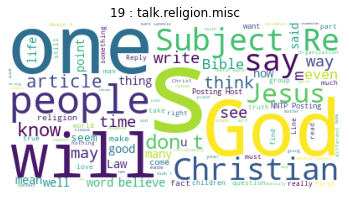

In [24]:
Y_pred = kmeans.predict(vectors)
for y in np.unique(Y_pred) : 
    y_words = data[np.where(Y == y)[0]]
    y_words = ' '.join(y_words)
    y_words = del_punc(y_words)

    wordcloud = WordCloud(background_color = 'white', max_words = 100, stopwords = STOPWORDS).generate(y_words)
    plt.figure()
    plt.title(str(y)+" : "+newsgroups_train.target_names[y])
    plt.imshow(wordcloud)
    plt.axis("off")

In [25]:
#purity

In [26]:
from sklearn.metrics import rand_score
rand_score(Y_pred, Y)

0.8852879124091465

In [27]:
from sklearn.metrics.cluster import adjusted_rand_score
adjusted_rand_score(Y_pred, Y)

0.11120721708814237

# 2) Latent Semantic Analysis (LSA <=> SVD) 


**Remember the LSA factorziation**: 
$$ 
\begin{matrix} 
 & X  &\!\!\!\!\!=\!\!\!\!\!& U  & \Sigma & V^T \\
  & \textbf{t}_j   &  & \hat{ \textbf{d}_i} & &  \\
 & \downarrow  &  &\downarrow  & & \\
\textbf{d}_i \rightarrow 
&
\begin{pmatrix} 
x_{1,1} & \dots & x_{1,d} \\
\\
\vdots & \ddots & \vdots \\
\\
x_{N,1} & \dots & x_{N,d} \\
\end{pmatrix}
&
\!\!\!\!\!=\!\!\!\!\!
%&
%(\hat{ \textbf{t}_j}) \rightarrow
&
\begin{pmatrix} 
\begin{pmatrix} &  \textbf{u}_1 &  \end{pmatrix} \\
\vdots \\
\begin{pmatrix}  & \textbf{u}_k &  \end{pmatrix}
\end{pmatrix}
%&
%\!\!\!\!\!\cdot\!\!\!\!\!
&
\begin{pmatrix} 
\sigma_1 & \dots & 0 \\
\vdots & \ddots & \vdots \\
0 & \dots & \sigma_k \\
\end{pmatrix}
%&
%\!\!\!\!\!\cdot\!\!\!\!\!
&
\begin{pmatrix} 
\begin{pmatrix} \, \\ \, \\ \textbf{v}_1 \\ \, \\ \,\end{pmatrix} 
\dots
\begin{pmatrix} \, \\ \, \\ \textbf{v}_k \\ \, \\ \, \end{pmatrix}
\end{pmatrix}
\end{matrix}
$$

- Look at [SVD doc in skelarn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html#sklearn.decomposition.TruncatedSVD)
- Do the same qualitative/quantitative evaluation than with K-Means
- You can also use LSA as a pre-processing step for K-Means, *i.e.* running K-Means on $\boldsymbol{U}$ matrix above
    - N.B. : try without/with $\ell_2$ normalization of $\boldsymbol{U}$'s rows before running  K-Means
    - You can also benefit from LSA pre-processing for using [t-SNE visualization](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) (see code below)


In [28]:
# t-SNE from the U matrix computed by LSA
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=20)
U = svd.fit_transform(vectors)

tsne = TSNE(n_components=2, init='pca',n_iter=5000, verbose=2)
tsne_mat = tsne.fit_transform(U)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 11314 samples in 0.002s...
[t-SNE] Computed neighbors for 11314 samples in 0.293s...
[t-SNE] Computed conditional probabilities for sample 1000 / 11314
[t-SNE] Computed conditional probabilities for sample 2000 / 11314
[t-SNE] Computed conditional probabilities for sample 3000 / 11314
[t-SNE] Computed conditional probabilities for sample 4000 / 11314
[t-SNE] Computed conditional probabilities for sample 5000 / 11314
[t-SNE] Computed conditional probabilities for sample 6000 / 11314
[t-SNE] Computed conditional probabilities for sample 7000 / 11314
[t-SNE] Computed conditional probabilities for sample 8000 / 11314
[t-SNE] Computed conditional probabilities for sample 9000 / 11314
[t-SNE] Computed conditional probabilities for sample 10000 / 11314
[t-SNE] Computed conditional probabilities for sample 11000 / 11314
[t-SNE] Computed conditional probabilities for sample 11314 / 11314
[t-SNE] Mean sigma: 0.069710
[t-SNE] Computed cond

[t-SNE] Iteration 3800: error = 1.8685728, gradient norm = 0.0004423 (50 iterations in 2.079s)
[t-SNE] Iteration 3850: error = 1.8682016, gradient norm = 0.0004295 (50 iterations in 2.303s)
[t-SNE] Iteration 3900: error = 1.8678771, gradient norm = 0.0004588 (50 iterations in 2.106s)
[t-SNE] Iteration 3950: error = 1.8675207, gradient norm = 0.0004782 (50 iterations in 1.955s)
[t-SNE] Iteration 4000: error = 1.8671718, gradient norm = 0.0004531 (50 iterations in 1.938s)
[t-SNE] Iteration 4050: error = 1.8668360, gradient norm = 0.0004438 (50 iterations in 1.961s)
[t-SNE] Iteration 4100: error = 1.8664546, gradient norm = 0.0004672 (50 iterations in 1.961s)
[t-SNE] Iteration 4150: error = 1.8661188, gradient norm = 0.0004786 (50 iterations in 1.964s)
[t-SNE] Iteration 4200: error = 1.8657814, gradient norm = 0.0004844 (50 iterations in 1.978s)
[t-SNE] Iteration 4250: error = 1.8654560, gradient norm = 0.0004414 (50 iterations in 2.458s)
[t-SNE] Iteration 4300: error = 1.8651330, gradien

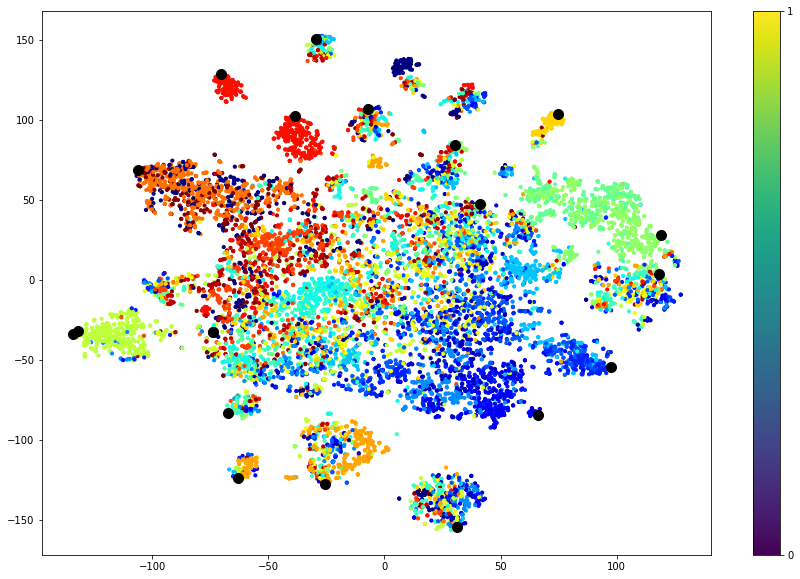

In [29]:
NN2cluster = np.argmax(np.abs(U), axis=0)
#import seaborn as sns
import matplotlib.cm as cm
cmap = cm.tab20
cmap = cm.get_cmap('hsv', 20) 
cmap = cm.get_cmap('jet', 20)
#cmap = cm.tab20

plt.figure(figsize=(15,10))
plt.scatter(tsne_mat[:,0],tsne_mat[:,1], c=Y, cmap=cmap, s=10)
plt.scatter(tsne_mat[NN2cluster[:],0],tsne_mat[NN2cluster[:],1], c='black', s=100)
#plt.scatter(tsne_mat[NN2cluster2[:],0],tsne_mat[NN2cluster2[:],1], c='red', s=100)
plt.colorbar(ticks=range(20))

# 3) Latent Dirichlet Allocation (LDA)

Perform the same experiments with LDA:
- LDA
https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html


**Start with a CountVectorizer**

In [30]:
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import CountVectorizer

# Initialize regex tokenizer
tokenizer = RegexpTokenizer(r'\w+')

# Vectorize document using TF-IDF
vectorizer = CountVectorizer(lowercase=True,
                        stop_words='english',
                        ngram_range = (1,1),
                        tokenizer = tokenizer.tokenize, max_df=0.95, min_df=2, max_features=1000)

vectors = vectorizer.fit_transform(newsgroups_train.data)
print(vectors.shape)
print(vectors.nnz / float(vectors.shape[0]))



/home/nour/.local/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(11314, 1000)
48.02527841612162


## LDA-viz

In [31]:
from sklearn.decomposition import LatentDirichletAllocation

#!pip install install pyldavis
from __future__ import print_function

import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

lda_viz = LatentDirichletAllocation(n_components=2, random_state=0)
lda_viz.fit(vectors)

pyLDAvis.sklearn.prepare(lda_viz,vectors,vectorizer)

AttributeError: 'CountVectorizer' object has no attribute 'get_feature_names'

# Performances evaluation

**Compare the different approaches wrt three quantitative metrics.**

In [ ]:
#purity
#rand_score
#adjusted_rand_score